<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_25_biGRU_2layer_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_25_biGRU_2layer_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Di Directional 2 Layer GRU Prototype With Attention

Previous notebook we implemented a [single layer GRU](https://github.com/sv650s/sb-capstone/blob/master/2019-07-22-GRU_prototype.ipynb) without attention

For this notebook, we will implement a 2 layer GRU network with attention and 3 dense layer architecture


As before, I am using some utility functions so I don't have copy so much code around. Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, Dropout, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()


Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"




In [4]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

## Preprocessing

*  Preprocessing data file and create the right inputs for Keras models
     *   Features:
        * tokenize
        * pad features into sequence
     *   Labels:
       *  one hot encoder
* split between training and testing

See [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) for souce code

In [6]:
X_train, X_test, y_train, y_test, tokenizer, max_sequence_length = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                      keep_percentile=0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Building Our GRU Model

In [0]:
from keras.engine.topology import Layer
from keras import backend as K
import keras


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
MODEL_NAME = "biGRU_2layer_attention"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(tokenizer.word_counts)+1
GRU_DIM = 250 # total GRU units

In [9]:
from keras.layers import CuDNNGRU

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_sequence_length))
model.add(Bidirectional(CuDNNGRU(GRU_DIM*2, return_sequences=True)))
model.add(Bidirectional(CuDNNGRU(GRU_DIM, return_sequences=True)))
model.add(AttentionLayer(max_sequence_length))
model.add(Dense(GRU_DIM*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(GRU_DIM, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


W0730 02:05:08.311762 139944347457408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 02:05:08.315583 139944347457408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 02:05:08.319534 139944347457408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 02:05:09.959806 139944347457408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 02:05:09.970196 

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 186, 1000)         2406000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 186, 500)          1878000   
_________________________________________________________________
attention_layer_1 (Attention (None, 500)               686       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
__________

In [11]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='auto', 
                           verbose=1,
                          restore_best_weights=True)

mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=tokenizer)


network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[reduce_lr, early_stop])

W0730 02:05:10.148432 139944347457408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 159s 2ms/step - loss: 0.9638 - acc: 0.6324 - val_loss: 0.8871 - val_acc: 0.6612
Epoch 2/50
67225/67225 [==============================] - 156s 2ms/step - loss: 0.7742 - acc: 0.6977 - val_loss: 0.8405 - val_acc: 0.6717
Epoch 3/50
67225/67225 [==============================] - 166s 2ms/step - loss: 0.6809 - acc: 0.7345 - val_loss: 0.8575 - val_acc: 0.6726
Epoch 4/50
67225/67225 [==============================] - 186s 3ms/step - loss: 0.6011 - acc: 0.7688 - val_loss: 0.9052 - val_acc: 0.6629
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


## Evaluating the Model

In [12]:
mw.evaluate(X_test, y_test)

Running model.evaluate...
28011/28011 [==============================] - 40s 1ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


In [13]:
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Accuracy: 67.69%


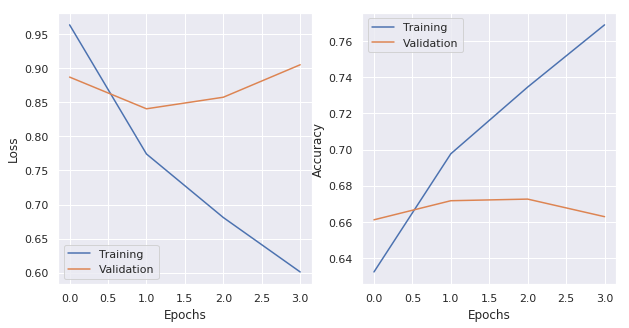

In [14]:
pu.plot_network_history(mw.network_history)

In [15]:
mw.confusion_matrix

array([[ 3216,    54,   297,    67,   334],
       [  947,    52,   436,   176,   260],
       [  544,    44,   720,   615,   608],
       [  161,    22,   372,  1501,  2696],
       [  209,    10,   175,  1024, 13471]])

In [16]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.63      0.81      0.71      3968
           2       0.29      0.03      0.05      1871
           3       0.36      0.28      0.32      2531
           4       0.44      0.32      0.37      4752
           5       0.78      0.90      0.84     14889

    accuracy                           0.68     28011
   macro avg       0.50      0.47      0.46     28011
weighted avg       0.63      0.68      0.64     28011



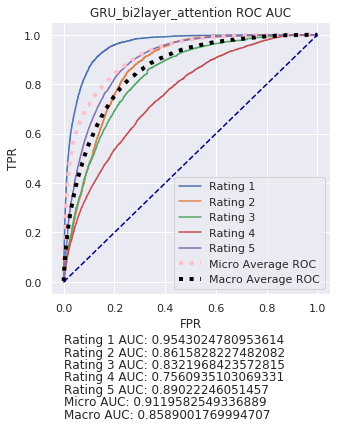

In [17]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

## Save off filees

In [18]:
mw.save(DRIVE_DIR, append_report=True)
mw.get_report().to_df()

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi2layer_attention-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi2layer_attention-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi2layer_attention-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.676877,"{""1"": {""precision"": 0.6334449478038211, ""recal...","[[3216, 54, 297, 67, 334], [947, 52, 436, 176,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,13.37,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.830913,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_bi2layer_attention,<keras.callbacks.History object at 0x7f469db69...,13.37,"{""auc_1"": 0.9543024780953614, ""auc_2"": 0.86158...",success,2019-07-30 02:17:59,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.00806451...",84032.0,186.0,13.37


In [24]:
loaded = pd.read_csv(mw.report_file, quotechar="'")
loaded

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.677591,"{""1"": {""precision"": 0.5852581521739131, ""recal...","[[3446, 71, 158, 50, 243], [1141, 90, 287, 120...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,32.59,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.835665,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_1layer,<keras.callbacks.History object at 0x7f5403610...,32.59,"{""auc_1"": 0.9527249533513878, ""auc_2"": 0.86096...",success,2019-07-30 01:46:31,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.0078125,...",84032.0,186.0,32.59
1,0.666845,"{""1"": {""precision"": 0.6141875505254648, ""recal...","[[3039, 150, 206, 95, 385], [892, 132, 293, 16...",review_body-word2vec5-111909-512-nolda-DNN_340...,word2vec,10.98,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.866301,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_340_batchnorm,<keras.callbacks.History object at 0x7f976c0f4...,10.98,"{""auc_1"": 0.9450905669619495, ""auc_2"": 0.84615...",success,2019-07-30 01:50:37,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00103225...",83931.0,512.0,10.98
2,0.679019,"{""1"": {""precision"": 0.6480066102045032, ""recal...","[[3137, 62, 476, 40, 253], [843, 60, 603, 132,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,8.79,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.823435,186.0,drive/My Drive/Springboard/capstone/models/ama...,biGRU_1layer_attention,<keras.callbacks.History object at 0x7f6df2f58...,8.79,"{""auc_1"": 0.9540099546947473, ""auc_2"": 0.86369...",success,2019-07-30 01:51:39,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01058467...",84032.0,186.0,8.79
3,0.668990,"{""1"": {""precision"": 0.6134569850039463, ""recal...","[[3109, 147, 201, 93, 325], [911, 128, 310, 19...",review_body-word2vec5-111909-512-nolda-DNN_384...,word2vec,17.84,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846571,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_384_384,<keras.callbacks.History object at 0x7fab83bd1...,17.84,"{""auc_1"": 0.9488228396143968, ""auc_2"": 0.85419...",success,2019-07-30 01:58:04,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,17.84
4,0.668704,"{""1"": {""precision"": 0.5902151922015818, ""recal...","[[3209, 64, 239, 83, 280], [994, 75, 341, 179,...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,4.85,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.848801,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128,<keras.callbacks.History object at 0x7f87970b1...,4.85,"{""auc_1"": 0.9489704320035117, ""auc_2"": 0.85306...",success,2019-07-30 01:58:55,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00051612...",83931.0,512.0,4.85
5,0.667918,"{""1"": {""precision"": 0.5995067349649023, ""recal...","[[3160, 127, 223, 80, 285], [972, 119, 316, 18...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,6.92,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846016,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128_batchnorm,<keras.callbacks.History object at 0x7f62cd50f...,6.92,"{""auc_1"": 0.949632140558062, ""auc_2"": 0.854176...",success,2019-07-30 02:08:19,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,6.92
6,0.676877,"{""1"": {""precision"":

In [20]:
print(f"Last run {datetime.now()}")

Last run 2019-07-30 02:19:59.708156


# Compare 2 Layer GRU with Attention to 1 Layer GRU without Attention

In [25]:
# let's see all the model repoorts that we saved off from before
loaded.model_name

0                GRU_1layer
1         DNN_340_batchnorm
2    biGRU_1layer_attention
3               DNN_384_384
4               DNN_128_128
5     DNN_128_128_batchnorm
6    biGRU_2layer_attention
Name: model_name, dtype: object

In [0]:
display_df = loaded[loaded.model_name.str.contains("GRU")]

In [27]:
display_df[["model_name", "accuracy"]].T

,0,2,6
model_name,GRU_1layer,biGRU_1layer_attention,biGRU_2layer_attention
accuracy,0.677591,0.679019,0.676877


In [36]:
import json
import pprint
for index, row in display_df.iterrows():
  print(f'Confusion Matrix - {row.model_name}:')
  pprint.pprint(json.loads(row.confusion_matrix))
  print()


Confusion Matrix - GRU_1layer:
[[3446, 71, 158, 50, 243],
 [1141, 90, 287, 120, 233],
 [734, 114, 628, 460, 595],
 [258, 48, 414, 1234, 2798],
 [309, 15, 197, 786, 13582]]

Confusion Matrix - biGRU_1layer_attention:
[[3137, 62, 476, 40, 253],
 [843, 60, 603, 132, 233],
 [452, 42, 944, 475, 618],
 [147, 7, 516, 1050, 3032],
 [262, 4, 235, 559, 13829]]

Confusion Matrix - biGRU_2layer_attention:
[[3216, 54, 297, 67, 334],
 [947, 52, 436, 176, 260],
 [544, 44, 720, 615, 608],
 [161, 22, 372, 1501, 2696],
 [209, 10, 175, 1024, 13471]]



In [42]:
# reconstruction a data frame to display the classification_report
cr = pd.DataFrame()
for index, row in display_df.iterrows():
  flattened = {}
  flattened = du.add_dict_to_dict(flattened, json.loads(row.classification_report))
  flattened["model_name"] = row.model_name
  cr = cr.append(flattened, ignore_index=True)
  
cr.set_index("model_name").T


model_name,GRU_1layer,biGRU_1layer_attention,biGRU_2layer_attention
1_f1-score,0.699269,0.712226,0.711111
1_precision,0.585258,0.648007,0.633445
1_recall,0.868448,0.790575,0.810484
1_support,3968.000000,3968.000000,3968.000000
2_f1-score,0.081485,0.058651,0.050658
2_precision,0.266272,0.342857,0.285714
2_recall,0.048103,0.032068,0.027793
2_support,1871.000000,1871.000000,1871.000000
3_f1-score,0.297983,0.355891,0.317811
3_precision,0.372922,0.340303,0.360000


In [44]:
# reconstruction a data frame to display roc_auc
cr = pd.DataFrame()
for index, row in display_df.iterrows():
  flattened = {}
  flattened = du.add_dict_to_dict(flattened, json.loads(row.roc_auc))
  flattened["model_name"] = row.model_name
  cr = cr.append(flattened, ignore_index=True)
  
cr.set_index("model_name").T


model_name,GRU_1layer,biGRU_1layer_attention,biGRU_2layer_attention
auc_1,0.952725,0.954010,0.954302
auc_2,0.860960,0.863699,0.861583
auc_3,0.824941,0.831802,0.832197
auc_4,0.750702,0.757932,0.756094
auc_5,0.890541,0.892850,0.890222
auc_macro,0.855994,0.860079,0.858900
auc_micro,0.911163,0.913316,0.911958


# Conclusion

Generally we are seeing the 1 Layer GRU Attention is performing better than 2 Layer GRU with Attention, and 2 Layer GRU with attention performs better than 1 Layer GRU without Attention

When you look at classfication report as well as AUC for almost all classes - 1 layer GRU with attention is performing better than the other 2 models

* Accuracy decreased by overall 1% when we implemented the 2 layer bidirecitonal GRU with attention compared to 1 layer without attention and only slightly better than 1 layer with Attentiion

* 1 layer GRU without attention identified the most number of Star 2 ratings which has the highest recall however, the precision is the lowers of the 3 models meaning that it tends to mis-classify something else as Star 2 as well


Overall, I would choose 1 layer GRU with attention over the other 2 models as it performs better in star rating 2 wihout much tradeoff at all in the other classes